In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob
from scipy.signal import convolve2d
import cv2
import spam.label
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import remove_small_holes
%matplotlib inline
from scipy.ndimage import correlate
from skimage.filters import threshold_otsu

In [2]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

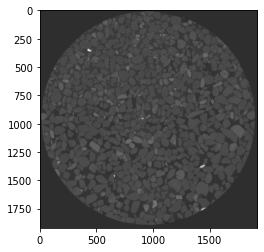

In [3]:
filename = '/home/hasitha/Desktop/data/tescan_high/recon_zoom_00151.tif'
oneimage = tif.imread(filename)
plt.imshow(oneimage,cmap='gray')

In [5]:
resized = cv2.resize(oneimage, (1000,1000), interpolation=cv2.INTER_CUBIC)

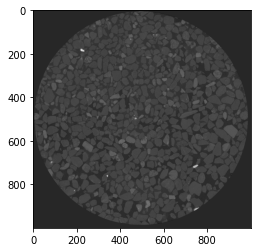

In [6]:
plt.imshow(resized,cmap='gray')

In [7]:
resized.shape

(1000, 1000)

In [4]:
np.arange(0,10,2)

array([0, 2, 4, 6, 8])

In [4]:
oneimage.shape

(1919, 1919)

In [6]:
layers = 1500
full_img = np.zeros((750,1000,1000))

for i in np.arange(0,layers,2):
    file = '/home/hasitha/Desktop/data/tescan_high/recon_zoom_' + '{:05d}'.format(i+200)+'.tif'
    img = tif.imread(file)
    full_img[i//2] = cv2.resize(img, (1000,1000), interpolation=cv2.INTER_CUBIC)
    
for i in np.arange(750):
    _min, _max = np.min(full_img[i]), np.max(full_img[i])
    full_img[i] = (full_img[i] - _min)/(_max - _min) * (65536-1)

In [7]:
binary = np.zeros((750,1000,1000),dtype=np.bool)

In [8]:
for i in np.arange(750):
    thresh = threshold_otsu(full_img[i])
    binary[i] = full_img[i] > thresh

In [9]:
binary.nbytes

750000000

In [10]:
tif.imsave('/home/hasitha/Desktop/packed_img/full_belgium.tif', binary)

In [14]:
full_img.shape

(750, 1000, 1000)

In [15]:
tif.imsave('/home/hasitha/Desktop/packed_img/gray_full_belgium.tif', full_img)

In [20]:
#tif.imsave('/home/hasitha/Desktop/packed_img/lab_full_belgium.tif', labelled)

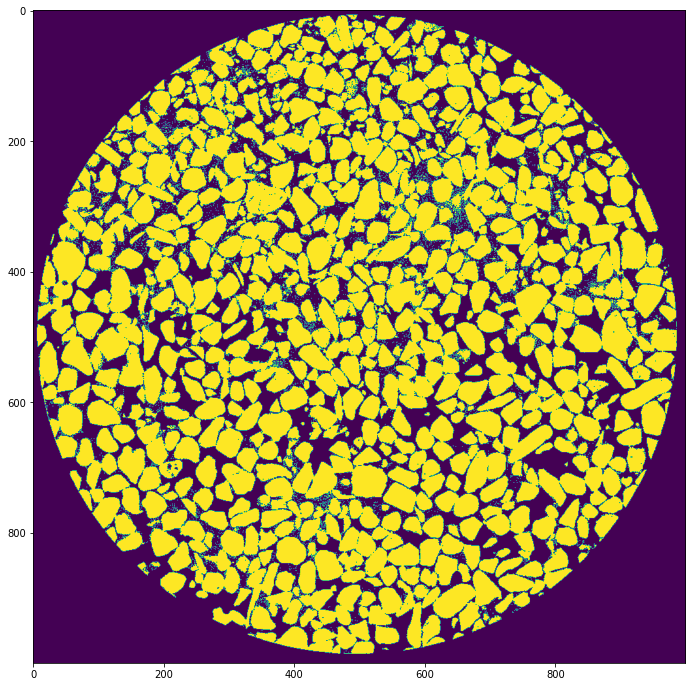

In [13]:
plt.figure(figsize=(12,12))
plt.imshow(binary[29])

In [16]:
labelled = spam.label.watershed(binary)

In [19]:
labelled.shape

(750, 1000, 1000)

In [18]:
np.max(labelled)

28450

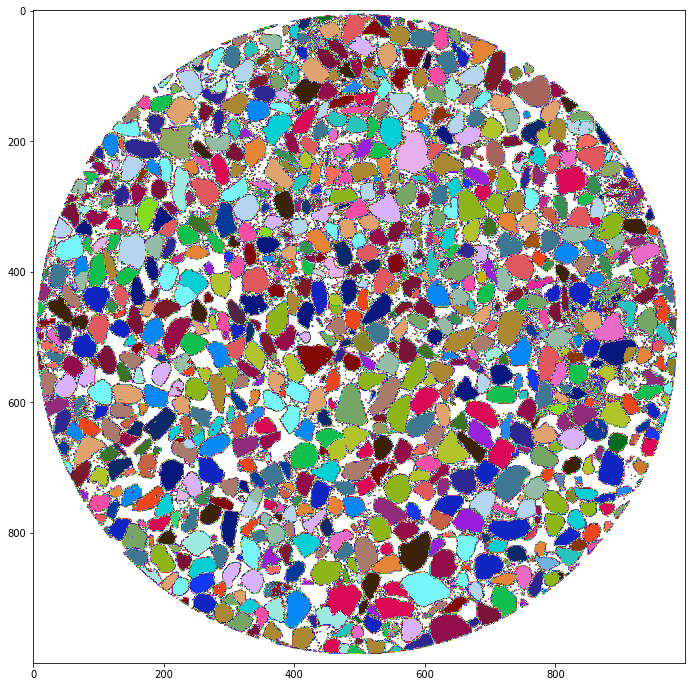

In [21]:
plt.figure(figsize=(12,12))
plt.imshow(labelled[170], cmap=spam.label.randomCmap)

In [11]:
labelled0 = spam.label.watershed(binary[0])

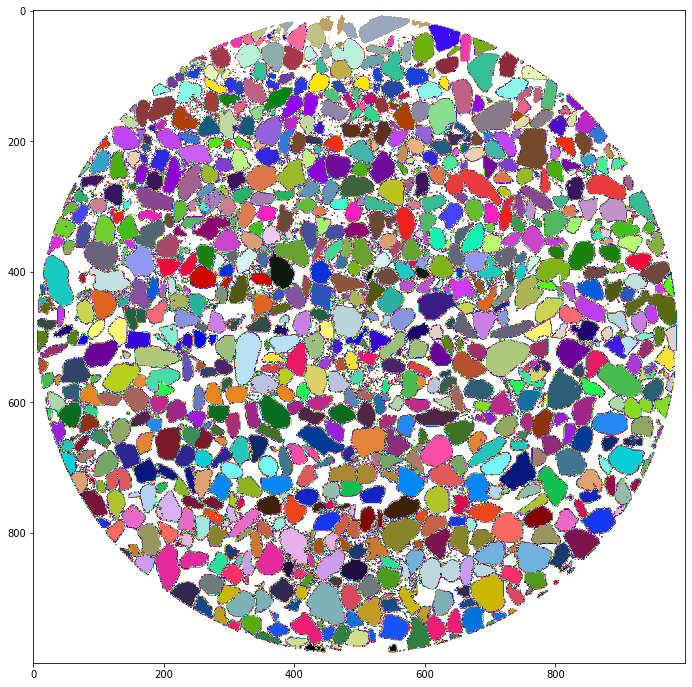

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(labelled0, cmap=spam.label.randomCmap)

In [13]:
bt = full_img[100] > thresh

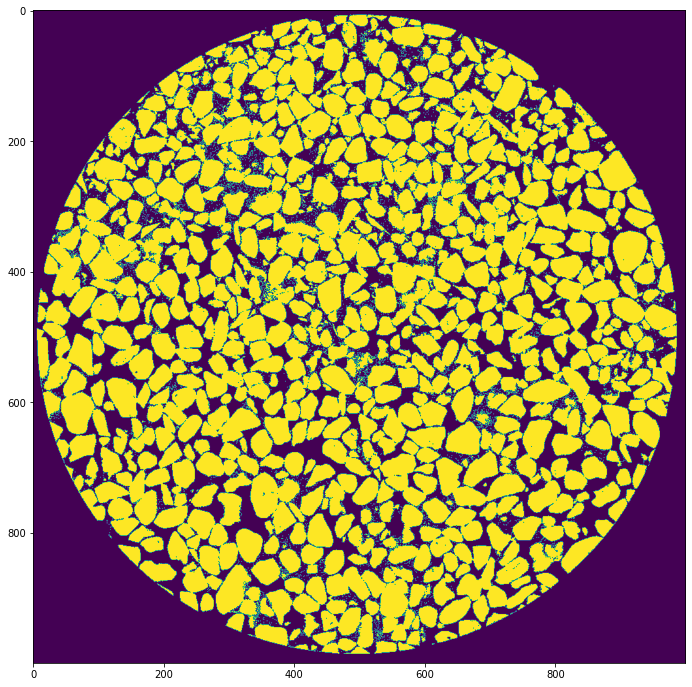

In [15]:
plt.figure(figsize=(12,12))
plt.imshow(bt)

In [6]:
np.max(full_img)

65535.0

In [7]:
full_img.shape

(400, 400, 400)

In [8]:
def image_normalization(img, L):
    """
    img: np.ndarray:
    L  : power of 2
    """
    _min, _max = img.min(), img.max()
    img = ((img-_min)/(_max-_min)*(L-1)).astype(np.uint16)
    return img

def image_histogram(img, L, disp=False):
    img = image_normalization(img, L)
    out = np.zeros(L)
    for i in np.arange(L):
        out[i] = np.sum(img==i)
    if disp:
        plt.figure(figsize=(8,8))
        plt.bar(np.arange(L), out)
        plt.title('image histogram, L = {}'.format(L))
        #plt.savefig('/home/hasitha/Desktop/image_paper/grenoble_histograim', dpi=500, bbox_inches=None)
        plt.show()
    return out

# this does not give better result, do not use it
def histogram_equalization(img, L, disp=False):
    img = image_normalization(img, L)
    hist = image_histogram(img, L)
    mapping = np.zeros(L)
    for i in np.arange(L):
        mapping[i] = int((L-1)*np.sum(hist[:i+1]))
    mapper = np.vectorize(lambda x: mapping[x])
    out = mapper(img)
    out = image_normalization(out, L)
    
    if disp:
        plt.figure(figsize=(8,8))
        plt.imshow(out, plt.cm.gray)
        plt.title('image after equalization')
        plt.show()
    return out

In [9]:
nlm_img = np.zeros(full_img.shape)
for idx in np.arange(layers):
    if idx%50==0: print('processing {}-th image'.format(idx))
    sigma_est = np.mean(estimate_sigma(full_img[idx], multichannel=False))
    nlm_img[idx] = denoise_nl_means(full_img[idx], h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False)
    
for i in np.arange(layers):
    nlm_img[i] = image_normalization(nlm_img[i],65536).astype(np.uint16)

processing 0-th image
processing 50-th image
processing 100-th image
processing 150-th image
processing 200-th image
processing 250-th image
processing 300-th image
processing 350-th image


In [6]:
"""
img_size = nlm_img.shape
layer_size = nlm_img[0].shape
binaries = np.zeros(img_size, dtype=np.bool)
kernel = np.ones((2,2))
for i in np.arange(img_size[0]):
    thresh = threshold_otsu(nlm_img[i])
    binaries[i] = nlm_img[i] > thresh
    binaries[i] = cv2.morphologyEx(np.float32(binaries[i]), cv2.MORPH_OPEN, kernel,iterations=1).astype(np.bool)
    remove_small_holes(binaries[i], area_threshold=100, connectivity=8, in_place=True)
    if(i % 100 == 0): print(i)
tif.imsave('/home/hasitha/Desktop/packed_img/fabric_600.tif', binaries)
"""

"\nimg_size = nlm_img.shape\nlayer_size = nlm_img[0].shape\nbinaries = np.zeros(img_size, dtype=np.bool)\nkernel = np.ones((2,2))\nfor i in np.arange(img_size[0]):\n    thresh = threshold_otsu(nlm_img[i])\n    binaries[i] = nlm_img[i] > thresh\n    binaries[i] = cv2.morphologyEx(np.float32(binaries[i]), cv2.MORPH_OPEN, kernel,iterations=1).astype(np.bool)\n    remove_small_holes(binaries[i], area_threshold=100, connectivity=8, in_place=True)\n    if(i % 100 == 0): print(i)\ntif.imsave('/home/hasitha/Desktop/packed_img/fabric_600.tif', binaries)\n"

In [12]:
img_size = nlm_img.shape
layer_size = nlm_img[0].shape
binaries = np.zeros(nlm_img.shape, dtype=np.bool)
kernel = np.ones((3,3))
for i in np.arange(img_size[0]): #img_size[0]
    data = nlm_img[i].reshape(-1,1)
    num_samples = np.prod(layer_size)
    num_clusters = 2
    num_dims = 1
    beta = 1.
    new_label, energy, params = EM_calc(num_dims, num_samples, num_clusters, data, \
            (1,layer_size[0],layer_size[1]), void_weight=1.00, beta = beta, verbose=False)
    print('{}-th layers completed'.format(i))
    binaries[i] = new_label.reshape(layer_size).astype(np.bool)

"""
idx = 0
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(binaries[idx],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(full_img[idx],cmap='gray')
print(energy)
"""

require 15 steps to finish, mu = [ 6261.442 13121.866]
0-th layers completed
require 15 steps to finish, mu = [ 5969.517 12791.742]
1-th layers completed
require 15 steps to finish, mu = [ 6523.978 13191.151]
2-th layers completed
require 15 steps to finish, mu = [ 6360.574 12973.285]
3-th layers completed
require 15 steps to finish, mu = [ 6222.474 12739.167]
4-th layers completed
require 15 steps to finish, mu = [ 6886.207 13389.803]
5-th layers completed
require 15 steps to finish, mu = [ 6962.721 13393.706]
6-th layers completed
require 15 steps to finish, mu = [ 6308.375 12728.88 ]
7-th layers completed
require 15 steps to finish, mu = [ 5908.463 12355.493]
8-th layers completed
require 15 steps to finish, mu = [ 6266.164 12772.813]
9-th layers completed
require 15 steps to finish, mu = [ 6555.119 13099.475]
10-th layers completed
require 15 steps to finish, mu = [ 6237.601 12738.704]
11-th layers completed
require 15 steps to finish, mu = [ 6299.241 12819.784]
12-th layers comple

require 15 steps to finish, mu = [13551.153 26151.179]
106-th layers completed
require 15 steps to finish, mu = [10942.664 21991.259]
107-th layers completed
require 15 steps to finish, mu = [10124.76  21619.385]
108-th layers completed
require 15 steps to finish, mu = [13330.096 27343.498]
109-th layers completed
require 15 steps to finish, mu = [14085.634 28648.54 ]
110-th layers completed
require 15 steps to finish, mu = [14615.744 28977.35 ]
111-th layers completed
require 15 steps to finish, mu = [11604.332 23523.492]
112-th layers completed
require 15 steps to finish, mu = [11747.313 21757.806]
113-th layers completed
require 15 steps to finish, mu = [ 8804.67  18285.073]
114-th layers completed
require 15 steps to finish, mu = [ 8838.96  18135.549]
115-th layers completed
require 15 steps to finish, mu = [ 9354.677 18708.576]
116-th layers completed
require 15 steps to finish, mu = [10264.711 20568.34 ]
117-th layers completed
require 15 steps to finish, mu = [11045.319 22736.68

require 15 steps to finish, mu = [ 7700.525 16030.89 ]
210-th layers completed
require 15 steps to finish, mu = [ 7306.059 15798.421]
211-th layers completed
require 15 steps to finish, mu = [ 7456.02  16122.336]
212-th layers completed
require 15 steps to finish, mu = [ 7253.446 15972.705]
213-th layers completed
require 15 steps to finish, mu = [ 7071.222 15718.675]
214-th layers completed
require 15 steps to finish, mu = [ 7459.029 16339.291]
215-th layers completed
require 15 steps to finish, mu = [ 7156.506 15910.063]
216-th layers completed
require 15 steps to finish, mu = [ 8027.909 16742.68 ]
217-th layers completed
require 15 steps to finish, mu = [ 7191.848 16071.05 ]
218-th layers completed
require 15 steps to finish, mu = [ 6940.244 16033.036]
219-th layers completed
require 15 steps to finish, mu = [ 7858.325 17369.829]
220-th layers completed
require 15 steps to finish, mu = [ 8381.783 19164.313]
221-th layers completed
require 15 steps to finish, mu = [10159.073 22971.81

require 15 steps to finish, mu = [ 9791.987 18661.365]
314-th layers completed
require 15 steps to finish, mu = [10738.871 19385.779]
315-th layers completed
require 15 steps to finish, mu = [ 8721.061 18007.17 ]
316-th layers completed
require 15 steps to finish, mu = [ 9328.323 18690.557]
317-th layers completed
require 15 steps to finish, mu = [10431.32 19813.13]
318-th layers completed
require 15 steps to finish, mu = [ 9600.115 19370.315]
319-th layers completed
require 15 steps to finish, mu = [ 9938.536 19022.395]
320-th layers completed
require 15 steps to finish, mu = [ 9937.895 18956.212]
321-th layers completed
require 15 steps to finish, mu = [10231.548 19394.93 ]
322-th layers completed
require 15 steps to finish, mu = [ 9442.526 19060.736]
323-th layers completed
require 15 steps to finish, mu = [ 9486.159 18877.877]
324-th layers completed
require 15 steps to finish, mu = [ 9388.189 18871.21 ]
325-th layers completed
require 15 steps to finish, mu = [ 9566.227 19356.536]

"\nidx = 0\nplt.figure(figsize=(12,12))\nplt.subplot(1,2,1)\nplt.imshow(binaries[idx],cmap='gray')\nplt.subplot(1,2,2)\nplt.imshow(full_img[idx],cmap='gray')\nprint(energy)\n"

In [13]:
tif.imsave('/home/hasitha/Desktop/packed_img/impulse_400.tif', binaries)
#tif.imsave('/home/hasitha/Desktop/packed_img/gray_highres_700.tif', full_img)

In [14]:
water = spam.label.watershed(binaries,verbose=True)

	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.


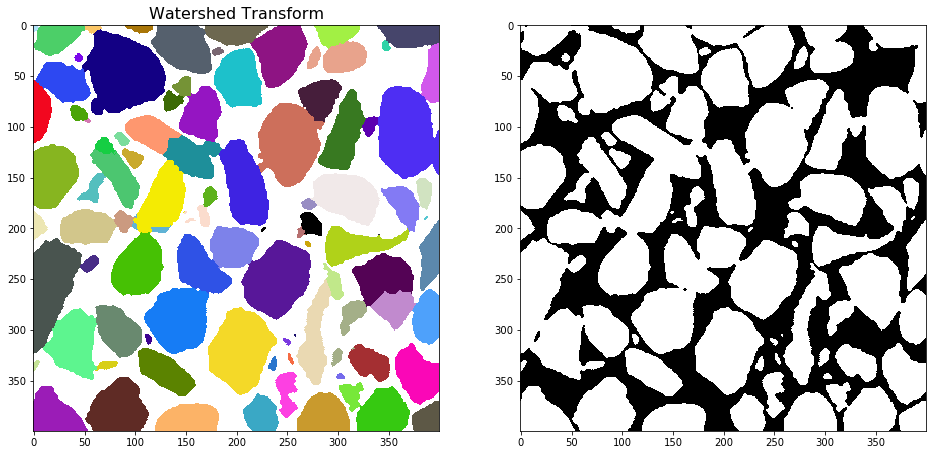

In [17]:
idx = 35
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(water[idx],cmap=spam.label.randomCmap)
plt.title('Watershed Transform',fontsize=16)
plt.subplot(1,2,2)
plt.imshow(binaries[idx],cmap='gray')

In [15]:
np.max(water)

1013

In [18]:
#tif.imsave('/home/hasitha/Desktop/packed_img/lab_impulse_400.tif', water)
#tif.imsave('/home/hasitha/Desktop/packed_img/pluviated_600_2.tif', binaries)
#tif.imsave('/home/hasitha/Desktop/packed_img/gray_impulse_400.tif', nlm_img)

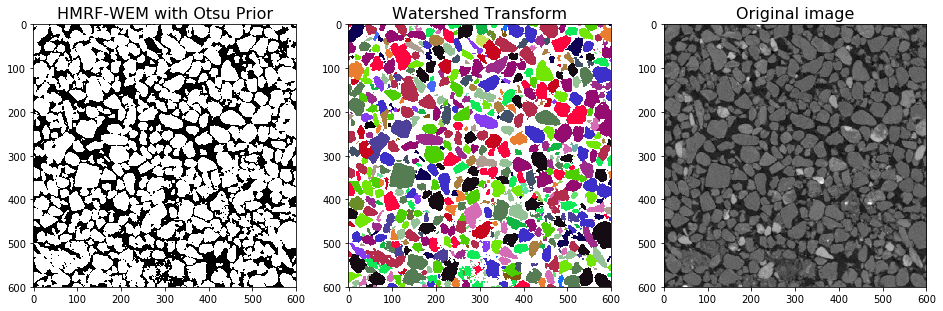

In [15]:
idx = 373
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
#thresh = threshold_otsu(nlm_img[idx])
plt.imshow(binaries[idx],plt.cm.gray)
#plt.imshow(nlm_img[idx]>thresh, plt.cm.gray)
plt.title('HMRF-WEM with Otsu Prior',fontsize=16)
plt.subplot(1,3,2)
plt.imshow(water[idx],cmap=spam.label.randomCmap)
plt.title('Watershed Transform',fontsize=16)
plt.subplot(1,3,3)
plt.imshow(nlm_img[idx],cmap='gray')
plt.title('Original image',fontsize=16)
#plt.savefig('blurry_whole_failure_case.png',dpi=500, bbox_inches=None)
plt.show()

In [10]:
def simple_binary_algorithm(data, thresh, num_dims):
    """
        Only useful for binary case
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_dims: number of dimension
        thresh: threshold 
        Output:
        ------------------------------------------------------
        label: initial labelled 
        mu: update centroid of each cluster
        sigma: update variance of each cluster
    """
    binary_clusters = 2
    mu = np.zeros((binary_clusters, num_dims))
    sigma  = np.zeros((binary_clusters, num_dims, num_dims))
    
    mu[0] = np.mean(data[data<=thresh], axis=0)
    mu[1] = np.mean(data[data>thresh], axis=0)
    sigma[0] = np.cov(data[data<=thresh].T)
    sigma[1] = np.cov(data[data>thresh].T)
    label = data>thresh
    
    return label, mu, sigma

def otsu_binary_algorithm(data, num_dims):
    """
        Only useful for binary case
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_dims: number of dimension
        Output:
        ------------------------------------------------------
        label: initial labelled 
        mu: update centroid of each cluster
        sigma: update variance of each cluster
    """
    otsu_clusters = 2
    thresh = threshold_otsu(data)
    mu = np.zeros((otsu_clusters, num_dims))
    sigma  = np.zeros((otsu_clusters, num_dims, num_dims))
    
    mu[0] = np.mean(data[data<=thresh], axis=0)
    mu[1] = np.mean(data[data>thresh], axis=0)
    sigma[0] = np.cov(data[data<=thresh].T)
    sigma[1] = np.cov(data[data>thresh].T)
    label = data>thresh
    
    return label, mu, sigma

def kmeans_initial_guess(data, num_samples, num_clusters):
    """
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        Output:
        ------------------------------------------------------
        mu: numpy array, randomly pick num_clusters value from data as
            initial guess
    """
    mu = data[np.random.choice(num_samples, num_clusters, False),:]
    return mu

def kmeans_get_label(data, num_samples, num_clusters, mu):
    """
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        mu: numpy array, centroid of each cluster
        Output:
        ------------------------------------------------------
        label: set all dataset points (pixels) to the best cluster according
            to minimal distance from centroid of each cluster
    """
    dist = np.zeros((num_samples, num_clusters))
    for k in range(num_clusters):
        dist[:,k] = np.linalg.norm(data - mu[k], axis=1)

    label = np.argmin(dist, axis=1)
    return label

def kmeans_get_means(data, num_dims, num_clusters, label):
    """
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_dims: number of dimension
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        label: label for dataset points (pixels) to the best cluster according
            to minimal distance from centroid of each cluster
        Output:
        ------------------------------------------------------
        mu: update centroid of each cluster
        sigma: update variance of each cluster
    """
    mu = np.zeros((num_clusters, num_dims))
    sigma  = np.zeros((num_clusters, num_dims, num_dims))
    for k in range(num_clusters):
        idx_list = np.where(label == k)[0]
        if(len(idx_list) == 0):
            mu[k] = data[np.random.randint(len(data)), :]
            sigma[k] = np.eye(num_dims)
        else:
            mu[k] = np.mean(data[idx_list], axis = 0)
            sigma[k] = np.cov(data[idx_list].T) # Remember to check this
    return mu, sigma

def kmeans_calc_loss(data, num_samples, num_clusters, mu, label):
    """
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        label: label for dataset points (pixels) to the best cluster according
            to minimal distance from centroid of each cluster
        mu: updated centroid of each cluster
        Output:
        ------------------------------------------------------
        return loss to determine convergence criterion
    """
    loss = 0
    for k in range(num_clusters):
        idx_list = np.where(label == k)[0]
        loss += np.sum(np.linalg.norm(data[idx_list]-mu[k], axis=1))
    return loss

def k_means_algorithm(data, num_samples, num_clusters, num_dims, verbose=False):
    """
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        num_dims: number of dimension of data, always 1 for pixels or voxels
        Output:
        ------------------------------------------------------
        labels: a list contains all segementation label from each iteration
        losses: a list contains all loss from each iteration
        mu: a list contains centroid of each cluster from each iteration
        sigma: a list contains variance of each cluster from each iteration
    """
    losses = []
    iter_cnt = 0
    epsilon = 1e-4
    max_iters = 100
    update = 2*epsilon

    #initial guess
    mus = [kmeans_initial_guess(data, num_samples, num_clusters)]
    sigmas = [np.eye(num_dims)*num_clusters]

    while (update > epsilon) and (iter_cnt < max_iters):
        iter_cnt += 1
        # Assign labels to each datapoint based on cnetroid
        label = kmeans_get_label(data, num_samples, num_clusters, mus[-1])

        # Assign centroid based on labels
        mu, sigma = kmeans_get_means(data, num_dims, num_clusters, label)
        mus.append(mu)
        sigmas.append(sigma)
        
        # Calculate loss
        losses.append(kmeans_calc_loss(data, num_samples, num_clusters, mus[-1], label))

        # Check convergence
        if iter_cnt >= 2:
            update = np.abs(losses[-1]-losses[-2])

        # Logging
        if verbose:
            print('iteration {}, update {}'.format(iter_cnt, update))
    if verbose:
        print('mu = {}, losses = {}'.format(mus[-1].flatten(), losses))

    return label, mus[-1], sigmas[-1], losses[-1]

def gaussian_U(data, mu, sigma, w):
    """
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        mu: centroid of each cluster
        sigma: variance of each cluster
        w: weight ratio between void and particle
        Output:
        ------------------------------------------------------
        return gaussian energy on each pixels
    """
    return 0.5*np.einsum('i,ij,ji->i',w,data-mu,np.linalg.inv(sigma)@(data-mu).T)+0.5*np.log(np.linalg.det(sigma)/w)

def clique_U(label, c, img_size):
    temp = label.reshape(img_size)
    tag1 = temp == c
    tag2 = temp != c
    constraints = np.zeros(img_size)
    constraints[tag1] = 0.
    constraints[tag2] = 1.
    kernel = np.array([[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]],[[1.,1.,1.],[1.,0.,1.],[1.,1.,1.]],[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]])
    #kernel = np.array([[[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]],[[1.,1.,1.],[1.,0.,1.],[1.,1.,1.]],[[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]]])
    return correlate(constraints, kernel, mode='nearest').flatten()

def EM_initial_guess(data, num_samples, num_clusters, num_dims):
    """
        run this for multiple time, make sure good initialization
        EM alogirthm is very sensitive to initialization
        use K-means to determine initial means and variances
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        num_dims: number of dimension of data, always 1 for pixels or voxels
        Output:
        ------------------------------------------------------
        label: final segementation label from each iteration
        mu: final centroid of each cluster from each iteration
        sigma: final variance of each cluster from each iteration
    """
    label, mu, sigma = otsu_binary_algorithm(data, num_dims)
    #label, mu, sigma = simple_binary_algorithm(data, 30, num_dims)
    #label, mu, sigma, loss = k_means_algorithm(data, num_samples, num_clusters, num_dims, verbose=False)
    return label, mu, sigma

def EM_E_step(num_clusters, num_samples, data, label, mu, sigma, beta, img_size, w):
    """
        Main goal: compute posterior of each cluster
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        label: hidden label configuration
        mu: means for each cluster in finite mixture model
        sigma: variance for each cluster in finite mixture model
        beta: ratio between Gaussian energy and clique potential energy
        img_size: image size, used to reconstruct spatial relationship
        Output:
        ------------------------------------------------------
        Uarg: cluster label corresponds to minimal energy for each pixel
        Umin: minimum energy of current configuration
        Q: posterior corresponds to each cluster
    """
    U1 = np.zeros((num_samples, num_clusters)) # Gaussian Energy
    U2 = np.zeros((num_samples, num_clusters)) # clique potential Energy

    for k in range(num_clusters):
        U1[:,k] = gaussian_U(data, mu[k], sigma[k], w)
        U2[:,k] = clique_U(label, k, img_size)

    U = U1 + U2
    #for i in np.arange(num_clusters):
    #    print('ratio between U2 and U1+U2 is {}'.format(beta*np.sum(U2[:i])/np.sum(U[:i])))
    Umin = np.min(U, axis = 1)
    Uarg = np.argmin(U, axis = 1)
    Uenergy = np.sum(Umin)

    # Consier Q2 as prior
    Q1 = np.zeros((num_samples, num_clusters)) # Gaussian probability
    Q2 = np.zeros((num_samples, num_clusters)) # clique potential probability

    for k in range(num_clusters):
        Q1[:,k] = np.exp(-U1[:,k])
        Q2[:,k] = np.exp(-U2[:,k])
    #check here
    #Q1 = Q1 / np.sum(Q1, axis = 1).reshape(-1,1)
    #Q2 = Q2 / np.sum(Q2, axis = 1).reshape(-1,1)

    Q = Q1 * Q2
    Q = Q / np.sum(Q, axis = 1).reshape(-1,1)
    return Uarg, Uenergy, Q

def EM_M_step (num_clusters, num_dims, num_samples, Q, data, w):
    """
        Main goal: update parameters
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_dims: number of dimension
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        Q: posterior corresponds to each cluster
        w: weight ratio between void and particle
        Output:
        ------------------------------------------------------
        mu: updated mean
        sigma: updated variance
    """
    
    # M Step
    ## calculate the new mean and covariance for each gaussian by
    ## utilizing the new responsibilities
    mu      = np.zeros((num_clusters, num_dims))
    sigma   = np.zeros((num_clusters, num_dims, num_dims))

    ## The number of datapoints belonging to each gaussian
    num_samples_per_cluster = np.sum(Q, axis=0) #pi
    weighted_sum = np.einsum('i,ij->j',w,Q)

    for k in range(num_clusters):
        ## means
        mu[k] = 1./weighted_sum[k] * np.einsum('i,i,ij -> j', w, Q[:,k], data)
        centered_data = data-mu[k]

        ## covariances
        sigma[k] = 1./num_samples_per_cluster[k] * np.multiply(centered_data.T, w*Q[:,k])@centered_data

    return mu, sigma

def EM_calc (num_dims, num_samples, num_clusters, data, img_size, void_weight=1., beta = 1., verbose=False):
    """
        This is an almost antomotic method except one might need to select void_weight;
        void_weight could be meaningfully interpreted as sample density;
        Input:
        ------------------------------------------------------
        data: numpy array, flattened input image
        num_dims: number of dimension
        num_samples: number of pixels in image
        num_clusters: number of clusters (i.e. 2 in binary segementation)
        Q: posterior corresponds to each cluster
        void_weight: weight ratio between void and particle
        Output:
        ------------------------------------------------------
        label: hidden configuration
        energy_sum: energy_sum, used to determine convergence
        mu: updated mean
        sigma: updated variance
    """
    energy_sums     = []
    iter_cnt        = 0
    epsilon         = 1
    max_iters       = 15
    update          = 2*epsilon
    #beta            = 1.
    w               = np.ones(len(data))

    # initial guess
    label, mu, sigma = EM_initial_guess(data, num_samples, num_clusters, num_dims)
    label = label.astype(np.bool)
    mus    = [mu]
    sigmas = [sigma]

    while (update > epsilon) and (iter_cnt < max_iters):
        iter_cnt += 1

        # E - Step
        label, Uenergy, Q = EM_E_step(num_clusters, num_samples, data, label, mu, sigma, beta, img_size, w)
        label = label.astype(np.bool)
        energy_sums.append(Uenergy)

        # M - Step
        mu, sigma = EM_M_step(num_clusters, num_dims, num_samples, Q, data, w)

        mus.append(mu)
        sigmas.append(sigma)


        # check convergence
        if iter_cnt >= 2 :
            update = np.abs(energy_sums[-1] - energy_sums[-2])

        # logging
        if verbose:
            print("iteration {}, update {}, mean {}".format(iter_cnt, update, mu.flatten()))

        w = np.ones(len(data))
        # label == np.argmin(mu) corresponds to void
        w[label == np.argmin(mu)] = void_weight

    print('require {} steps to finish, mu = {}'.format(iter_cnt, mus[-1].flatten()))
    energy = energy_sums[-1]
    mu = mus[-1]
    sigma = sigmas[-1]
    label = label != np.argmin(mu)
    #label = label == np.argmax(mu)
    return label, energy_sums, {'mu': mu, 'sigma': sigma}


require 15 steps to finish, mu = [25849.635 15859.157]
49-th layers completed
[1487961.3195760292, 1518843.477971496, 1483447.063820025, 1489192.7307225894, 1488123.4640270418, 1489572.6943807919, 1489305.3939449023, 1488369.5164742586, 1487422.2674876873, 1486215.7367522533, 1484631.226261638, 1483283.346867375, 1482343.7898180801, 1481689.954157558, 1481232.036641181]


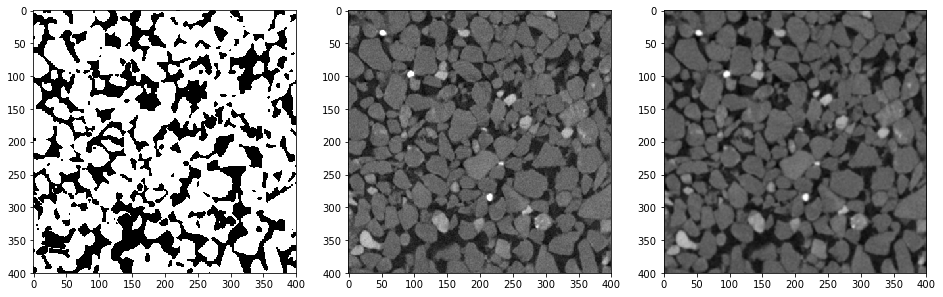

In [415]:
img_size = full_img.shape
layer_size = full_img[0].shape
kernel = np.ones((3,3))
idx = 0

denoised = gaussian_filter(full_img[idx],sigma=1)
data = denoised.reshape(-1,1)
num_samples = np.prod(layer_size)
num_clusters = 2
num_dims = 1
beta = 1.
new_label, energy, params = EM_calc(num_dims, num_samples, num_clusters, data, \
        (1,layer_size[0],layer_size[1]), void_weight=4.0, beta = beta, verbose=False)
print('{}-th layers completed'.format(i))
binary = new_label.reshape(layer_size).astype(np.bool)

plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(binary,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(full_img[idx],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(denoised,cmap='gray')
print(energy)

In [409]:
w15 = binary

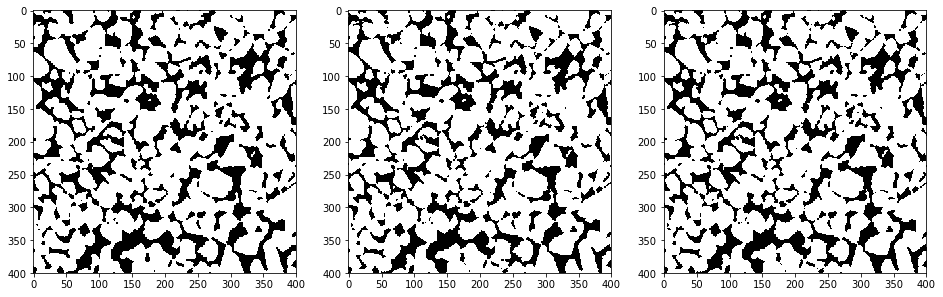

In [380]:
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(w25, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(wotsu, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(wk, cmap='gray')

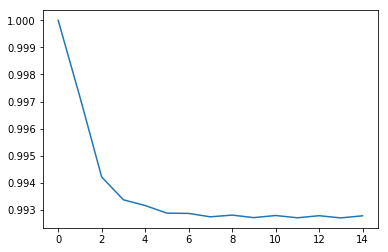

In [258]:
plt.plot(np.arange(len(energy)), energy/energy[0])

In [399]:
plt.imsave('/home/hasitha/Desktop/image_paper/grenoble_w25.tif',w25,cmap='gray')
plt.imsave('/home/hasitha/Desktop/image_paper/grenoble_w05.tif',w05,cmap='gray')
plt.imsave('/home/hasitha/Desktop/image_paper/grenoble_w1.tif',w1,cmap='gray')
plt.imsave('/home/hasitha/Desktop/image_paper/grenoble_w5.tif',w5,cmap='gray')

In [243]:
k_mean0 = binaries[0]

In [249]:
otsu0 = binaries[0]

In [246]:
hmrf0 = binaries[0]

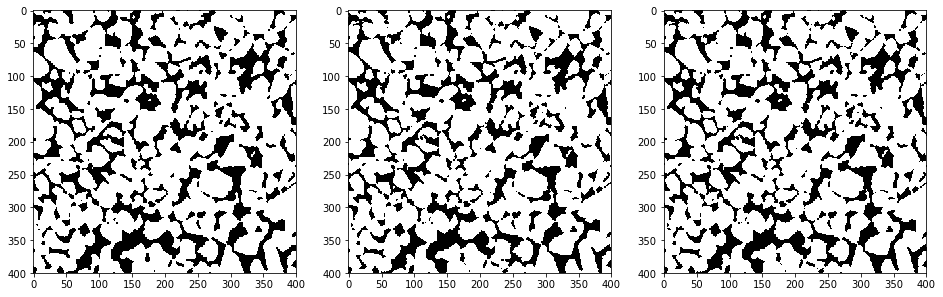

In [381]:
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(w25, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(wotsu, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(wk, cmap='gray')

In [382]:
water_k = spam.label.watershed(wk,verbose=True)
water_o = spam.label.watershed(wotsu,verbose=True)
water_h = spam.label.watershed(w25,verbose=True)

	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.
	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.
	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.


In [410]:
water_h = spam.label.watershed(w15,verbose=True)

	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.


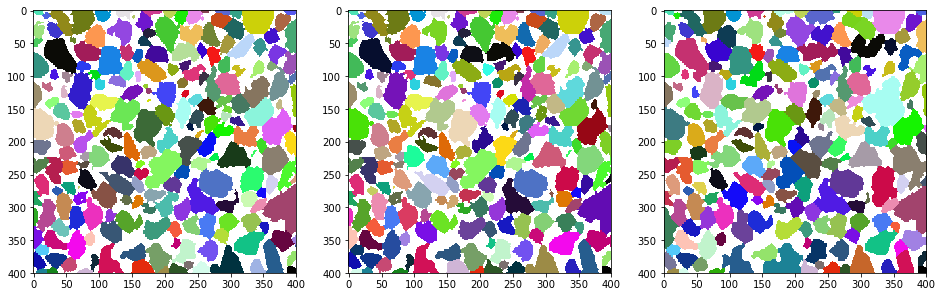

In [411]:
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(water_k, cmap=spam.label.randomCmap) # 217
plt.subplot(1,3,2) 
plt.imshow(water_o, cmap=spam.label.randomCmap) # 216
plt.subplot(1,3,3)
plt.imshow(water_h, cmap=spam.label.randomCmap) # 210

In [412]:
print(np.max(water_k))
print(np.max(water_o))
print(np.max(water_h))

217
216
193


In [385]:
plt.imsave('/home/hasitha/Desktop/image_paper/watershed_k_217.tif',water_k,cmap=spam.label.randomCmap)
plt.imsave('/home/hasitha/Desktop/image_paper/watershed_o_216.tif',water_o,cmap=spam.label.randomCmap)
plt.imsave('/home/hasitha/Desktop/image_paper/watershed_h_210.tif',water_h,cmap=spam.label.randomCmap)

In [387]:
plt.imsave('/home/hasitha/Desktop/image_paper/grenoble_lr.tif', full_img[0], cmap='gray')

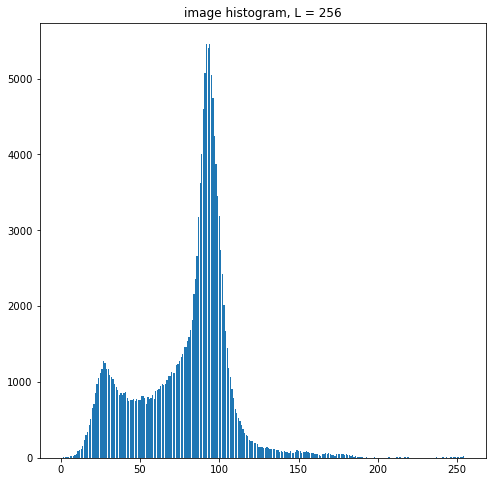

array([   1.,    0.,    5.,    4.,    4.,   13.,   19.,   20.,   24.,
         38.,   51.,   86.,  103.,  120.,  161.,  231.,  298.,  346.,
        436.,  510.,  661.,  714.,  860.,  975., 1046., 1117., 1175.,
       1270., 1251., 1166., 1176., 1087., 1072., 1045.,  969.,  935.,
        895.,  829.,  860.,  825.,  853.,  865.,  789.,  749.,  765.,
        766.,  780.,  747.,  776.,  761.,  768.,  818.,  815.,  792.,
        716.,  807.,  775.,  784.,  827.,  782.,  876.,  896.,  910.,
        946.,  971.,  965.,  973., 1025., 1078., 1077., 1130., 1121.,
       1124., 1219., 1242., 1279., 1323., 1364., 1462., 1459., 1544.,
       1595., 1687., 1813., 2155., 2360., 2667., 3180., 3624., 4002.,
       4594., 5079., 5462., 5406., 5456., 5053., 4745., 4250., 3880.,
       3459., 3187., 2735., 2430., 2018., 1675., 1452., 1189., 1060.,
        910.,  783.,  643.,  595.,  525.,  487.,  429.,  384.,  329.,
        300.,  286.,  233.,  225.,  224.,  192.,  195.,  180.,  138.,
        146.,  146.,

In [408]:
image_histogram(denoised,256,True)